In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.getcwd())

import numpy as np
from matplotlib import pyplot as plt

import torch
from torchvision.utils import make_grid
from torch_tools.visualization import to_image
import tensorflow as tf
import tensorflow_hub as hub

# Setup tf models

In [2]:
# setup BigGAN
bigGAN = hub.Module('https://tfhub.dev/deepmind/biggan-128/2')
inputs = {k: tf.placeholder(v.dtype, v.get_shape().as_list(), k)
          for k, v in bigGAN.get_input_info_dict().items()}
input_bigGAN_z = inputs['z']
input_bigGAN_y = inputs['y']
input_bigGAN_trunc = inputs['truncation']

output_bigGAN = bigGAN(inputs)

# setup BigBiGAN
bigbiGAN = hub.Module('https://tfhub.dev/deepmind/bigbigan-resnet50/1')
info = bigbiGAN.get_input_info_dict('generate')['z']
inpurt_bigbiGAN_z = tf.placeholder(dtype=info.dtype, shape=info.get_shape())
output_bigbiGAN = bigbiGAN(inpurt_bigbiGAN_z, signature='generate', as_dict=True)


sess = tf.InteractiveSession()
initializer = tf.global_variables_initializer()
sess.run(initializer)

# Show

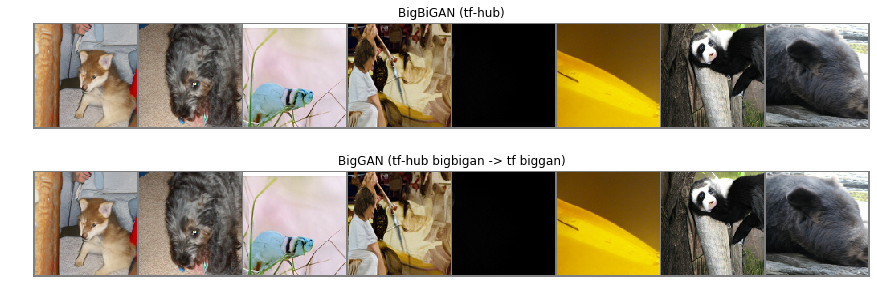

In [4]:
from tf_tools.bigbigan2biggan import bigbigan2biggan


batch_size = 8
z = np.random.randn(batch_size, 120)
y = np.zeros([batch_size, 1000])
y[:, 0] = 1


# Run bigGAN just to set all variables to be properly initialized
feed_dict = {input_bigGAN_z: z, input_bigGAN_y: y, input_bigGAN_trunc: 1.0}
img_biggan = sess.run(output_bigGAN, feed_dict=feed_dict)

transfers, conversions = bigbigan2biggan(bigbiGAN, bigGAN)
sess.run(transfers);

feed_dict = {inpurt_bigbiGAN_z: z}
img_bigbigan = sess.run(output_bigbiGAN, feed_dict=feed_dict)['default']
feed_dict = {input_bigGAN_z: z, input_bigGAN_y: y, input_bigGAN_trunc: 1.0}
img_biggan = sess.run(output_bigGAN, feed_dict=feed_dict)


plt.figure(figsize=(15, 5))
plt.subplot(211)
plt.title('BigBiGAN (tf-hub)')
plt.axis('off')
plt.imshow(to_image(make_grid(torch.from_numpy(img_bigbigan).permute(0, 3, 1, 2))))

plt.subplot(212)
plt.title('BigGAN (tf-hub bigbigan -> tf biggan)')
plt.axis('off')
plt.imshow(to_image(make_grid(torch.from_numpy(img_biggan).permute(0, 3, 1, 2))))

# tf BigGAN to torch

In [8]:
from tf_tools.tf_to_torch import convert_tf_to_torch

biggan_torch_from_tf = convert_tf_to_torch(128, sess=sess).eval()

Adding attention layer in G at resolution 64


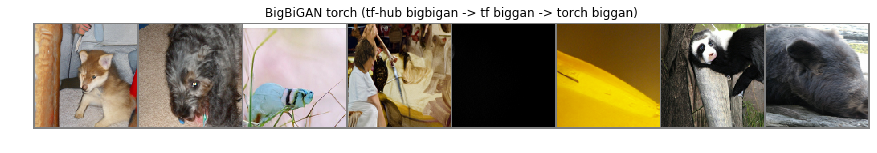

In [10]:
from BigGAN.gan_load import UnconditionalBigGAN
from scipy.stats import truncnorm

G_from_tf = UnconditionalBigGAN(biggan_torch_from_tf).to('cpu')
imgs_torch = G_from_tf(torch.from_numpy(z).float().cpu())

img_grid = make_grid(imgs_torch)
plt.figure(figsize=(15, 5))
plt.axis('off')
plt.title('BigBiGAN torch (tf-hub bigbigan -> tf biggan -> torch biggan)')
plt.imshow(to_image(img_grid))